# Nifty 500 Technical Exploratory Data Analysis and Stock Selection for Investment:

![bull v bear](https://i.imgur.com/2VuFhVB.png)

Professional trading and investment in stock market is one of the most elite and respected profession in modern world. This profession is considered both a science and an art. As it require a great deal of analysis to find a good stock for investment, and an art as it is a skill which anyone can learn with some honest hardwork and practice.

People who are successfully sustaining in the markets and making a fortune have few things in common. May it be a person who follows technical analysis or fundamental analysis, some thing that are common for both are:
- deciding a stoploss before making a position in any stock
- selecting a stock on a technical or fundamental basis rahter than making a speculation
- deciding a target (it's not mandator, as some people exit seeing the price action)
- keeping the approach mechanical and monotonous.

This exploratory data analysis on NIFTY 500 stocks will assist you in coming over some of those problems. Some of the things which will be covered extensively are:
- analysing the stocks on basis of relative strength
- assessing some KPIs for the stocks
- screening out stocks on basis of a technical screener
- setting a stop-loss as per the stock price volatility
- understanding the breadth of the stock
- understanding the underlying momentum for the trend of the stock
- confirming the selection with help of a widely used indicator for medium and long term investments.

# Source Code:

### Libraries:

In [ ]:
#installation
!pip install yfinance mplfinance ta --upgrade --quiet

#importation
import pandas as pd
import ta
import yfinance as yf
import warnings
import mplfinance as mpf
import plotly.express as px
import plotly.graph_objects as go
from datetime import date, timedelta
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings(action='ignore',category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Data Preprocessing:

### Content ETL:

In [ ]:
URL='https://www.traderscockpit.com/?pageView=nse-indices-stock-watch&index=NIFTY+500'

HTML_content=pd.read_html(URL)
dataset=HTML_content[3]

### Helper Functions:

Here are some helper functions which will be extensively used in futher analyses.

In [ ]:
# Adds .NS to the ticker symbol for analysis
def calibrate(ticker):
  return ticker+'.NS'

In [ ]:
# Returns only the ticker symbol for analysis
def decalibrate(ticker):
  return ticker.split('.')[0]

In [ ]:
# Return the entire history for each stock in a ticker series in form of a dataframe
def NSE500(series):
  NF=pd.DataFrame()

  for ticker in series:
    script=yf.download(ticker)
    script['Ticker']=ticker.split('.')[0]
    NF=NF.append(script)

  NF.insert(0,'Ticker',NF.pop('Ticker'))
  NF.dropna(inplace=True)
  NF.drop('Adj Close',axis=1,inplace=True) # dropping the adjusted close value as it isn't used much for technical analysis in stock indicators

  return round(NF,2)

In [ ]:
# Return history of each stock in a ticker series for a specified period only and saves it in a dataframe
def Ranged_NSE500(range_percentage,period,series):

  NF500=pd.DataFrame() #.............................................. forming an empty dataframe

  for ticker in series: #............................................. filling the empty dataframe
    script=yf.download(ticker,
                       start=date.today()-timedelta(days=period*2),
                       end=date.today())

    script['Ticker']=ticker.split('.')[0] #........................... adding ticker name as a column

    NF500=NF500.append(script) #...................................... appending script's data into the empty dataframe

  NF500.insert(0,'Ticker',NF500.pop('Ticker')) #...................... putting `Ticker` column in 0th  position
  NF500.dropna(inplace=True)
  NF500=NF500.drop('Adj Close', axis=1) #............................. dropping `Adj Close` column as it doesn't hold much significance
  NF500=NF500.groupby('Ticker').tail(period)

  return round(NF500,2)

In [ ]:
# Updates the ticker symbols in a series with user input ticker symbols
def TickerSymbolUpdate(series,given_symbols,updated_symbols):
  if len(given_symbols)!=len(updated_symbols):
    return ('symbol count mismatch...')

  for index in range(len(given_symbols)): #................................ takes input in form of a list
    for ticker_symbol in range(len(series)):
      if series[ticker_symbol]==(str(given_symbols[index])+'.NS'):
        series[ticker_symbol]=((updated_symbols[index])+'.NS')

  return

In [ ]:
# Drops the ticker symbol from ther series which user has specified
def TickerSymbolDrop(series,given_symbol):
  given_symbol=str(given_symbol)+'.NS' #................................... can only drop one ticker at a time
  series.remove(given_symbol)
  return

In [ ]:
# Returns user specified stock for a specified period
def fetch_stock(ticker,delta):
  ticker=calibrate(ticker)
  sample=yf.download(ticker,
                     start=date.today()-timedelta(weeks=delta),
                     end=date.today())
  return sample

### Ticker Series Creation:

This section exclusively covers the process of fetching and processing the ticker symbols for NSE500 stocks.

In [ ]:
ticker_series=sorted(dataset['Index'][1:501].to_list())
ticker_series=[calibrate(ticker) for ticker in ticker_series]

In [ ]:
TickerSymbolUpdate(ticker_series,given_symbols=['LTI','SRTRANSFIN','IIFLWAM'],updated_symbols=['LTIM','SHRIRAMFIN','360ONE'])

In [ ]:
TickerSymbolDrop(ticker_series,'INOXLEISUR')

The total number of stocks which will be analysed are mentioned below.

In [ ]:
print(f'There are {len(ticker_series)} scripts in ticker_series')

There are 499 scripts in ticker_series


### Nifty 500 DataFrame Creation:

In [ ]:
NSE_DF=NSE500(ticker_series)

After cleaning the data, the final dataframe has following row and column count.

In [ ]:
print(f'NSE500 dataframe in-use has {NSE_DF.shape[0]} rows and {NSE_DF.shape[1]} columns')

NSE500 dataframe in-use has 1913926 rows and 6 columns


# Analysis Functions and Indicators:

Here we will perform EDA with keeping certain KPIs and technical indicators as analysis parameters. Here we are creating the helper functions for the analysis along with the main functions which will be used for EDA process.

## Basic Information and KPIs:

In [ ]:
# Returns a series of ticker symbols which have certain parameter in their yahoo-finance information list
def clean(parameter):
  series=[]
  for ticker in ticker_series:
    if parameter in yf.Ticker(ticker).info: #.info returns all the historical data along with certain KPIs for analysis of a script
      series.append(ticker)

  return pd.Series(series)

In [ ]:
# Applies the parameter to the cleaned series and saves the final result in another series
def parameter_series(parameter):
  series=clean(parameter)
  parameter_series=[]
  for ticker in series:
    parameter_value=yf.Ticker(ticker).info[parameter]
    parameter_series.append(parameter_value)

  return pd.Series(parameter_series)

In [ ]:
# Joins the two series created above such that the value of parameter is in parallel to the ticker symbol
def parameter_dataframe(parameter):
  ticker_series=clean(parameter)
  para_series=parameter_series(parameter)
  parameter_dataframe=pd.concat([ticker_series,para_series],axis=1)
  parameter_dataframe.columns=['Ticker',parameter.capitalize()]

  return parameter_dataframe

In [ ]:
# Counts the frequency of certain parameter and returns it in dataframe format
def parameter_count(parameter):
  parameter_count=pd.DataFrame(parameter_series(parameter).value_counts())
  parameter_count.reset_index(inplace=True)
  parameter_count.columns=[parameter.capitalize(),'Count']

  return parameter_count

## Techincal Indicators:

### Correlation:

In [ ]:
# Returns the correlation factor between two in scripts (or index)
def Correlation(ticker1, ticker2='^CRSLDX',period=52):
  ticker1_dataframe=yf.download(calibrate(ticker1),
                                start=date.today()-timedelta(weeks=period),
                                end=date.today())
  ticker2_dataframe=yf.download((ticker2 if ticker2=='^CRSLDX' else calibrate(ticker2)),
                                start=date.today()-timedelta(weeks=period),
                                end=date.today())

  print('Correlation between', ticker1, 'and', ('NSE500' if ticker2=='^CRSLDX' else ticker2), f'is {round(ticker1_dataframe.Close.corr(ticker2_dataframe.Close),5)}')
  return

#### Relative Strength:

In [ ]:
def Relative_Strength(ticker_x, ticker_y='^CRSLDX', period=104):
  ticker_x_dataframe=yf.download(calibrate(ticker_x),
                                start=date.today()-timedelta(weeks=period),
                                end=date.today())
  ticker_y_dataframe=yf.download((ticker_y if ticker_y=='^CRSLDX' else calibrate(ticker_y)),
                                start=date.today()-timedelta(weeks=period),
                                end=date.today())

  close_x=pd.DataFrame(ticker_x_dataframe.Close)
  close_y=pd.DataFrame(ticker_y_dataframe.Close)

  close_x['normalized']=((close_x.Close-close_x.Close.min())/(close_x.Close.max()-close_x.Close.min()))
  close_y['normalized']=((close_y.Close-close_y.Close.min())/(close_y.Close.max()-close_y.Close.min()))
  Relative_DF=pd.merge(close_x, close_y, on='Date')
  Relative_DF.reset_index(inplace=True)

  return Relative_DF

In [ ]:
def Relative_Strength_Plot(ticker_x,ticker_y='^CRSLDX', period=52):
  Relative_DF=Relative_Strength(ticker_x, ticker_y, period)

  chart=px.line(Relative_DF,
                x='Date',
                y=['normalized_x','normalized_y'],
                title='Relative Strength')

  chart.update_layout(yaxis_title='Normalization Rate',
                      legend=dict(title='Ticker Symbols:',
                                  orientation='h',
                                  yanchor='bottom',
                                  y=1.02,
                                  xanchor='right',
                                  x=1))

  chart.update_traces(name=ticker_x,selector=dict(name='normalized_x'))
  chart.update_traces(name=('NSE500' if ticker_y=='^CRSLDX' else ticker_y),selector=dict(name='normalized_y'))

  chart.show()

#### Average True Range:

`ATR (Average True Range)` is an indicator used widely in the technical analysis domain. ATR along with some of it's derivatives like `ATR Trailing Stops`, `SuperTrend`, etc. are used to decide a reasonable stop-loss as per the volatility of a stock.

ATR is calculated a the maximum of the three values:
- Current Day High - Current Day Low
- Current Day High - Previous Day Close
- Current Day Low - Previous Day Close

The maximum value is called the `TR` or True Range for the day. Under a certain user-input period, the collection of these TRs is averaged out and we obtain our `ATR`.

$\boxed{TR=max[(H-L)|(H-PDC)|(L-PDC)]}$

$\boxed{ATR=\frac{Sum\ of\ all\ the\ TRs\ for\ period\ P}{Period\ P}}$

In [ ]:
def ATR(ticker,period=10,delta=52):
  ticker=calibrate(ticker)
  script_dataframe=yf.download(ticker,
                               start=date.today()-timedelta(weeks=delta),
                               end=date.today())

  script_dataframe['H-L']=abs(script_dataframe.High-script_dataframe.Low)
  script_dataframe['H-PDC']=abs(script_dataframe.High-script_dataframe.Close.shift(1)) #..... shift(1) will take the previous value of the very column
  script_dataframe['L-PDC']=abs(script_dataframe.Low-script_dataframe.Close.shift(1))
  script_dataframe['TR']=script_dataframe[['H-L','H-PDC','L-PDC']].max(axis=1) #............. finding the maximum value out of three columns for each row

  script_dataframe['ATR']=round(script_dataframe['TR'].rolling(period).mean(),2) #........... calculating ATR from the calculated TRs

  script_dataframe.drop(['H-L','H-PDC','L-PDC','TR'],axis=1,inplace=True) #.................. dropping the columns which aren't required to be displayed
  script_dataframe=script_dataframe.iloc[period:] #.......................................... avoiding NaN values by taking values staring after `period`

  return round(script_dataframe,2)

In [ ]:
def ATR_Plot(ticker,period=10):

  sample=ATR(ticker)

  Indicator=mpf.make_addplot(sample.ATR, type='line', color='black', width=0.5, panel=1, title='ATR') #.... adding ATR as an additional plot

  Parameters=dict(main_panel=0, #.......................................................................... making candle stick chart as the main plot
                  type='candle',
                  xrotation=0,
                  datetime_format='%B %Y',
                  figsize=(15,6),
                  panel_ratios=(4,1)) #.................................................................... deciding the panel ratios for appropriate fit

  mpf.plot(sample, **Parameters, addplot=Indicator)

#### Relative Strength Index:

`RSI` or Relative Strength Index is a lagging indicator which is widely used by both beginners and seasoned traders and investors. To understand this in simple words, RSI tells us about the breadth of certain stock.

Breadth means the status of stock under the scale starting from `over-sold` all the way up to `over-bought`. This scale ranges between `0 to 100`, where `0 depicts prior` and `100 depicts latter`.

When RSI value is below 30, a stock is considered over-sold and that for above 70 is considered over-bought. In both the conditions it is suggested not to place any order on such stocks as they can show high volatility and have a higher chance to show uncommon price action behviours.

In [ ]:
def RSI(ticker,period=14,delta=52):

  sample=fetch_stock(ticker,delta)
  sample['RSI']=ta.momentum.rsi(sample.Close,period) #................................................. using python `ta` libarary to use RSI

  return sample

In [ ]:
def RSI_Plot(ticker,period=14,delta=52):
  sample=RSI(ticker,period,delta)

  Indicator=mpf.make_addplot(sample.RSI, type='line', color='black', width=0.5, panel=1, title='RSI')
  Parameters=dict(main_panel=0,
                  type='candle',
                  xrotation=0,
                  datetime_format='%B %Y',
                  panel_ratios=(5,3),
                  figsize=(15,6))

  mpf.plot(sample, **Parameters, addplot=Indicator)

#### Stochastics Oscillator:

Stochastics is used for gauging the magnitude of the momentum based on the price history over a certain period.

$$momentum\ \alpha\ strength\ of\ trend $$

Stochastics oscillator follows a simple mathematical calculation:

$\boxed{Stochastics\ =\frac{Close-Low_{period}}{{High_{period}}-Low_{period}}}$

and `%D` is the smoothened `%K` over a period.

In [ ]:
def Stochastics(ticker,period=14,smooth=3,delta=52):

  sample=fetch_stock(ticker,delta)

  sample['L_period']=sample.Low.rolling(period).min() #......................................... finding the lowest low over the period
  sample['H_period']=sample.High.rolling(period).max() #........................................ findind the highest high over the period

  sample['%K']=round((sample.Close-sample.L_period)*100/(sample.H_period-sample.L_period),2) #.. calculating K%
  sample['%D']=round(sample['%K'].rolling(smooth).mean(),2) #................................... calculating D%

  sample=sample.drop(['L_period','H_period'],axis=1)
  sample=sample.dropna()
  return sample

In [ ]:
def Stochastics_Plot(ticker,period=14,smooth=3,delta=52):
  sample=Stochastics(ticker,period,smooth,delta)

  K=mpf.make_addplot(sample['%K'], type='line', color='r', width=0.5, panel=1, title='Stochastics')
  D=mpf.make_addplot(sample['%D'], type='line', color='black', width=0.5, panel=1)

  stoch=[K,D]

  Parameters=dict(type='candle',
                  main_panel=0,
                  figsize=(15,6),
                  panel_ratios=(5,3),
                  xrotation=0,
                  datetime_format='%B %Y')

  mpf.plot(sample, **Parameters, addplot=stoch)

### Narrow-Range Screener

`NARROW_RANGE` isn't any indicator which is present in the conventional lead-lag indicators. This is a screener instead which screens-in the stocks which have taken a small halt while following their trend.

To explain it in simple words, this screener takes a range percentage as parameter which will be used as filter and period as a parameter which counts the number of `D` candles to be taken under consideration.

So, `range_percentage = 5` and `period = 3` means that it will screen-in all the stocks which have their range's high (highest high in last 3 days) and range's low (lowest low in last 3 days) within a 5% price change (or range percentage).

In [ ]:
def Narrow_Range(range_percentage=2,period=3,series=ticker_series):
  script_dataframe=Ranged_NSE500(range_percentage,period,series) #........ taking the NSE500 dataframe as an input for analysis

  grouped_script=script_dataframe.groupby('Ticker') #................ grouping scripts data by ticker symbol for computation

  script_dataframe['Range_High']=grouped_script['High'].cummax() #... storing the maximum value High from the grouped dataframe
  script_dataframe['Range_Low']=grouped_script['Low'].cummin() #..... storing the minimum value Low from the grouped dataframe
  script_dataframe['Range_Percentage']=round((script_dataframe.Range_High-script_dataframe.Range_Low)*100/script_dataframe.Range_Low,2)
  script_dataframe=script_dataframe.groupby('Ticker').tail(1) #...... taking the last value as  it has highes high and lowest low for the mentioned period

  script_dataframe=script_dataframe[script_dataframe.Range_Percentage<=range_percentage]
  script_dataframe.sort_values('Range_Percentage',inplace=True)

  return script_dataframe

In [ ]:
def Candle_Sticks(ticker, delta=52):
  sample=yf.download(calibrate(ticker),
                     start=date.today()-timedelta(weeks=delta*1.25), #.......... taking a greater delta as some days will be discounted due to holidays
                     end=date.today())

  Parameters=dict(type='candle',
                  style='yahoo',
                  volume=True,
                  figsize=(15,6),
                  xrotation=0,
                  datetime_format='%B %Y')

  mpf.plot(sample, **Parameters) #.............................................. ** will unzip the contents of the dictionary

### Golden Cross:

Golden Cross is a highly respected indicator used across the stock market world. Golden Cross generally consists of 50 and 200 SMA, and whenever the faster MA crossed the slower MA we can consider to make a position at that point.

In [ ]:
def Golden_Cross(ticker,fast_MA=50,slow_MA=200,delta=104):

  sample=fetch_stock(ticker,delta)

  Parameters=dict(type='candle',
                  style='yahoo',
                  mav=(fast_MA,slow_MA), #........... adding moving averages to the graph
                  volume=True, #..................... adding volume indicator
                  figsize=(15,6),
                  xrotation=0,
                  datetime_format='%B-%Y')

  mpf.plot(sample, **Parameters)

# Exploratory Data Analysis:

### 0. How has NSE500 performed over the years and what are some of the insights which can be obtained by looking at the graph?

[*********************100%***********************]  1 of 1 completed


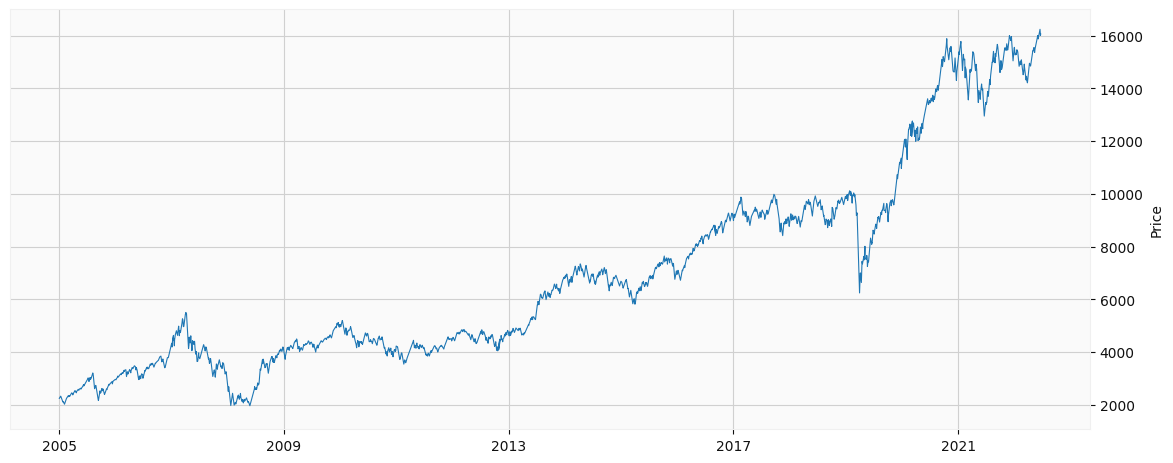

In [ ]:
NIFTY500=yf.download('^CRSLDX') #............................................ ^CRSLDX is ticker symbol for NSE500 index

mpf.plot(NIFTY500, #......................................................... plotting a line graph
         type='line',
         style='yahoo',
         figsize=(15,6),
         xrotation=0,
         datetime_format='%Y')

Here we can make alot of inferences by looking at the chart, some of the major studies which are worth mentioning are as follows:
1. Unlike the [recession in 2008](https://en.wikipedia.org/wiki/2007%E2%80%932008_financial_crisis), the fall in market during COVID-19 in 2019-2020 was pretty sharp, but it recovered very quickly as well.
2. Before 2019, we can notice that index price was in a channel, and after the recovery from [COVID-19 crash](https://www.thebalancemoney.com/fundamentals-of-the-2020-market-crash-4799950), the price had crossed it's all time high by breaking the market in the up-side.
3. As far as current scenario is concerned, the price was previously forming a range which has recently been broken and price has made it new all time high. Moreover, the price has broken the [resistance](https://www.investopedia.com/trading/support-and-resistance-basics/) with a [double-bottom pattern](https://www.investopedia.com/terms/d/doublebottom.asp) which indicates the strength in the [bull run](https://www.investopedia.com/terms/b/bullmarket.asp).
4. By understanding the above points, we can conclude that we might see a strong bull run in future, hence a long term investment on long side may result into some greens in their [portfolio](https://www.investopedia.com/terms/p/portfolio.asp).

### 1. What is the sector distribution for current NSE500 stock list?

In [ ]:
sector_distribution=parameter_dataframe('sector')
sector_distribution=sector_distribution.sort_values('Sector')

In [ ]:
chart=px.histogram(sector_distribution,
                   x='Sector',
                   title='Sector Distribution in NSE 500')

chart.update_layout(yaxis_title='Script Count',
                    xaxis_tickangle=-30)

chart.show()

Here we can notice that there is a major stock distribution in 4 sectors, namely:
- Basic Materials
- Consumer Cyclical
- Financial Services
- Industrial

### 2. What is the capital distribution of current NSE 500 stock list?

In [ ]:
capital_distribution=parameter_dataframe('marketCap')

In [ ]:
sector_capital_merge=pd.merge(capital_distribution,sector_distribution,on='Ticker')
sector_capital_merge=sector_capital_merge.groupby('Sector').sum()
sector_capital_merge.reset_index(inplace=True)
sector_capital_merge['In Trillions']=(sector_capital_merge['Marketcap']/10**12).apply(lambda x: '{:.2f}T'.format(x))

In [ ]:
chart=px.bar(sector_capital_merge.sort_values('Marketcap'),
             x='Marketcap',
             y='Sector',
             text='In Trillions',
             title="Market's Capital Distribution for NSE 500")

chart.update_layout(yaxis_title='Script Count',
                    xaxis_title='Market Capital (INR)')

chart.update_traces(hovertemplate='Market Capital : %{x:3f}<br>Sector : %{y}')

chart.show()

From here can we notice that Financial Services sector has the highest total capital amongst all the listed sectors. This tells that a major part of stock market is dominated by banking (to be broader, financial) sector.

### 3. What is the most common beta for NSE 500 stock list?

In [ ]:
beta_distribution=parameter_dataframe('beta')

In [ ]:
chart=px.histogram(beta_distribution,
                   x='Beta',
                   title='Beta Distribution Across NSE500 Listed Stocks',
                   marginal='rug')

chart.update_layout(bargap=0.05,
                    yaxis_title='Script Count')

chart.show()

**Beta** is a measure of a stock's volatility relative to the overall stock market. A stock with a higher beta has greater risk and expected returns. A beta of two means the stock is twice as volatile as the overall market, while a beta of 0.50 means the stock is half as volatile.

If we notice here, we can conclude that the majority of listed stocks lie in the beta range of 0.4 - 0.6 with a left-skew. This therefore suggests that majority of the stocks are not very volatile with a few outliers on the both side of the beta scale.

Therfore, we can understand that investing in NSE500 listed stock in  most cases will result in a slow but steady return which will not affect the portfolio too much.

### 4. What is the relation between market cap. and beta for listed stocks?

In [ ]:
merged_dataframe=pd.merge(pd.merge(capital_distribution, beta_distribution, how='outer', on='Ticker'), sector_distribution, how='outer', on='Ticker')

In [ ]:
chart=px.scatter(merged_dataframe,
                 x='Beta',
                 y='Marketcap',
                 color='Sector',
                 size='Marketcap',
                 title='Market Capital vs. Beta')

chart.update_layout(yaxis_title='Market Capital',
                    xaxis_title='Beta')

chart.update_traces(marker_opacity=0.5,
                    hovertemplate='Beta : %{x:.3f}<br>Market Capital : %{y}')

chart.show()

From here we can observe that the listed stocks with a larger capital are mostly present between of 0.5 - 1.0. This means it will be a safer investment if we will invest in the [large cap. stocks](https://www.investopedia.com/insights/understanding-small-and-big-cap-stocks/), which makes sense, and can be backed by the logic that large cap. stocks are traded more commonly which leads to higher [volume](https://www.investopedia.com/articles/technical/02/010702.asp), and higher volume results in less [volatility](https://www.investopedia.com/terms/v/volatility.asp).

### 5. Is there relation between quick ratio and beta value for different sectors?

In [ ]:
quickratio_distribution=parameter_dataframe('quickRatio')

In [ ]:
quick_beta_sector_merged=pd.merge(pd.merge(quickratio_distribution, beta_distribution, how='outer', on='Ticker'), sector_distribution, how='outer', on='Ticker')
quick_beta_sector_merged.dropna(inplace=True)

In [ ]:
chart=px.scatter(quick_beta_sector_merged,
                 x='Beta',
                 y='Quickratio',
                 color='Sector',
                 title='Beta vs. Quick Ratio',
                 hover_data=['Ticker'])

chart.update_traces(marker_opacity=0.5)

chart.show()

*The* **acid-test ratio**, also known as the quick ratio, is a liquidity ratio that measures a company's ability to pay its current liabilities with only quick assets. Quick assets are current assets that can be converted to cash within 90 days or in the short-term.

Although there isn't and direct reltion between beta and quick ratio directly, there surely is a pattern which can be noticed for a specific sector. Here we can notice that for most of the cases no matter what is the value of beta, the quick ratio is near zero only, except for financial sector. The quick ratio for a handful of scripts belonging to financial services is very high.

### 6. Using Narrow Range screener tell which stocks can be the best one's for investment purposes?

In [ ]:
Narrow_Range()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Ticker,Open,High,Low,Close,Volume,Range_High,Range_Low,Range_Percentage
Date,,,,,,,,,
2023-06-23,SUVENPHAR,485.40,488.20,483.60,486.40,163237,488.25,483.10,1.07
2023-06-23,KOTAKBANK,1833.00,1845.55,1823.90,1828.55,2584063,1849.75,1823.90,1.42
2023-06-23,RATNAMANI,2330.00,2339.90,2315.00,2333.35,10576,2350.00,2310.05,1.73
2023-06-23,ICICIBANK,926.05,931.90,919.00,923.50,8767733,935.55,919.00,1.80
2023-06-23,TITAN,2972.50,2981.00,2932.00,2939.15,869340,2985.00,2932.00,1.81
2023-06-23,TCS,3237.30,3249.40,3209.15,3216.35,1119505,3267.65,3209.15,1.82
2023-06-23,SUNPHARMA,994.00,995.95,977.30,991.45,1218237,996.20,977.30,1.93
2023-06-23,TCNSBRANDS,420.50,420.50,414.40,415.30,52892,421.85,413.80,1.95
2023-06-23,BAYERCROP,4297.00,4320.50,4256.05,4289.95,18558,4340.00,4256.05,1.97


A dummy script was screened-in for understanding the working of Narrow Range Screener on June,22. The screened-in stock was TITAN.

[*********************100%***********************]  1 of 1 completed


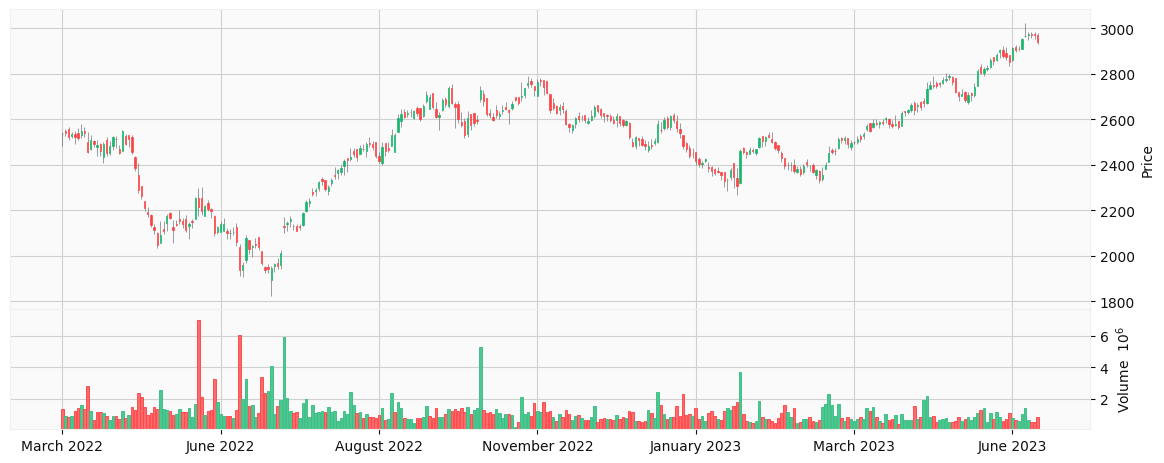

In [ ]:
Candle_Sticks('TITAN')

![TITAN 2023-06-23](https://i.imgur.com/F2Af5Rn.png)

As there we can see that there is a bull rally in TITAN's stock since late Feb, 2023 and we have a small halt in price currently, we can think about making an investment in TITAN.

### 7. How much is TITAN correlated to NSE500?

In general, stock correlation refers to how stocks move in relation to one another. While we can speak generally about asset classes being positively or negatively correlated, we can also specifically quantify correlation.

*“Stock correlation is on a scale from -1 to 1 and is calculated by looking at a pair of stocks over a time and figuring out their average movement,”* says Michael W. Landsberg, principal and chief investment officer at Landsberg Bennett Private Wealth Management in Punta Gorda, Florida.

In [ ]:
Correlation('TITAN')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Correlation between TITAN and NSE500 is 0.82157


### 8. What is the return-wise performance of TITAN when compared with NSE500?

Relative strength is a ratio of a stock price performance to a market average (index) performance used in technical analysis. It is not to be confused with relative strength index. To calculate the relative strength of a particular stock, divide the percentage change over some time period by the percentage change of a particular index over the same time period.

 Relative strength is a strategy used in momentum investing and identifying value stocks. It focuses on investing in stocks or other investments that have performed well relative to the market as a whole or to a relevant benchmark.

 The relative strength number of a stock indicates how well the stock has been performing over the last year compared to all other stocks in the database.

In [ ]:
Relative_Strength_Plot('TITAN')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Here we can notice that TITAN's chart is pretty similar to that of NSE500's chart, this concludes that the returns of TITAN were pretty close to that of NSE500, and therefore TITAN can be a good choice for making an investment.

### 9. What will be the SL (with 3ATR value) for TITAN if we decide to buy it today?

In [ ]:
ATR('TITAN').tail(1)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ATR
Date,,,,,,,
2023-06-23,2972.5,2981.0,2932.0,2939.15,2939.15,869340,43.84


[*********************100%***********************]  1 of 1 completed


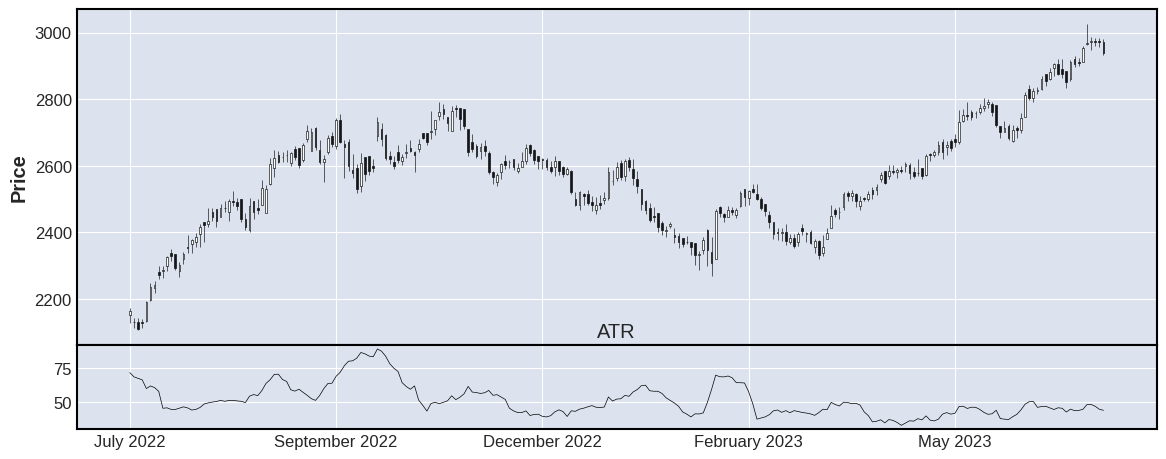

In [ ]:
ATR_Plot('TITAN')

In [ ]:
SL=pd.DataFrame((ATR('TITAN').Close.tail(1)-3*ATR('TITAN').ATR.tail(1)))
SL.columns=['Stop Loss']
SL

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Stop Loss
Date,
2023-06-23,2807.63


|Date|Stop Loss|
|---|---|
|2023-06-22 00:00:00|2836\.42|

If we make a buying decision, then we can put a stop loss at the above mention price point. This SL is calculated on the basis current volatility in the script.

The target can be set to 3 times the gap of SL, which means a 1:3 risk:reward investment.

### 10. What is the breadth of TITAN?

In [ ]:
RSI('TITAN').tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,RSI
Date,,,,,,,
2023-06-19,2967.000000,3024.399902,2963.350098,2968.600098,2968.600098,1382633,74.585977
2023-06-20,2972.699951,2986.350098,2948.300049,2974.000000,2974.000000,672298,75.059547
2023-06-21,2974.000000,2985.000000,2958.149902,2971.100098,2971.100098,509602,74.259264
2023-06-22,2975.000000,2984.750000,2955.800049,2970.250000,2970.250000,496441,74.010150
2023-06-23,2972.500000,2981.000000,2932.000000,2939.149902,2939.149902,869340,65.370295


[*********************100%***********************]  1 of 1 completed


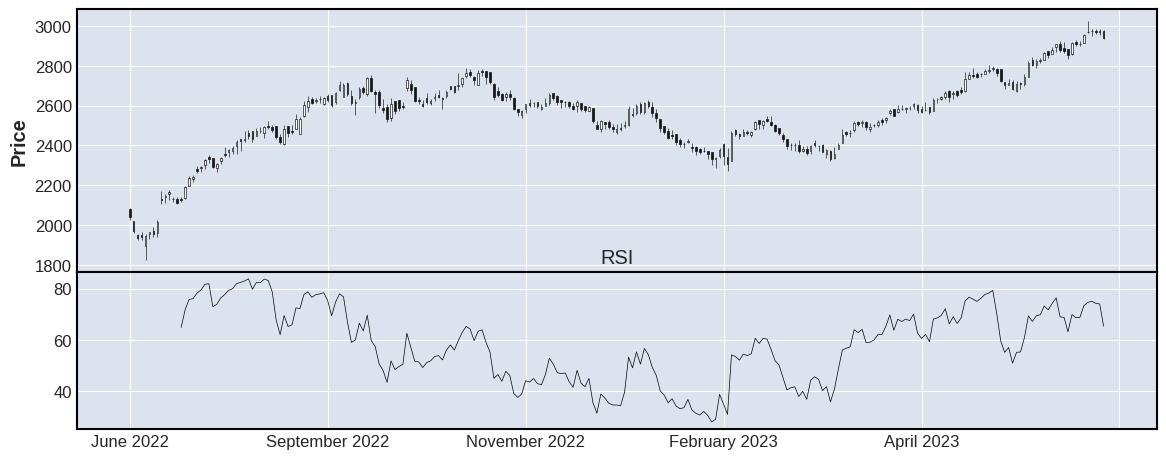

In [ ]:
RSI_Plot('TITAN')

|Date|Open|High|Low|Close|Adj Close|Volume|RSI|
|---|---|---|---|---|---|---|---|
|2023-06-22 00:00:00|2975\.0|2984\.75|2955\.800048828125|2970\.25|2970\.25|496441|74\.01014954501349|

Here we can see that the RSI value has crossed 70, which puts TITAN in the overbought breadth. So, we can either make a position in TITAN right away, or wait for a samll pull-back (like the one seen in May 2023) in the price to get a better SL.

### 11. What is the magnitude of momentum for TITAN?

In [ ]:
Stochastics('TITAN').tail(1)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,%K,%D
Date,,,,,,,,
2023-06-23,2972.5,2981.0,2932.0,2939.149902,2929.149902,869340,55.4,66.71


[*********************100%***********************]  1 of 1 completed


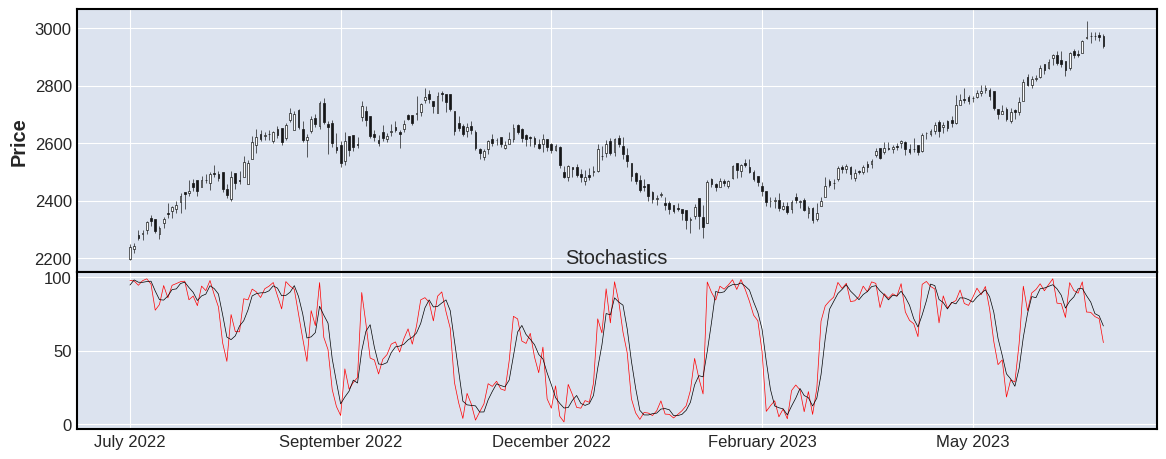

In [ ]:
Stochastics_Plot('TITAN')

|Date|Open|High|Low|Close|Adj Close|Volume|%K|%D|
|---|---|---|---|---|---|---|---|---|
|2023-06-22 00:00:00|2975\.0|2984\.75|2955\.800048828125|2970\.25|2960\.14404296875|496441|71\.67|73\.57|

Value of stochastics is way above 35, which indicates that the bullish momentum of TITAN stock is very strong and can be considered for buying.

### 12. Verify the decision of investing in TITAN using the Golden Cross.

[*********************100%***********************]  1 of 1 completed


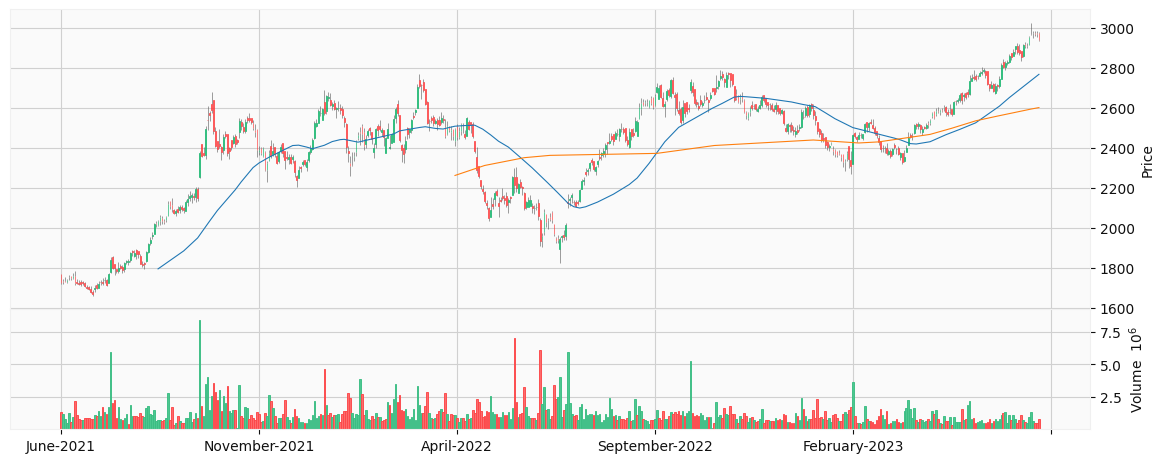

In [ ]:
Golden_Cross('TITAN')

Golden Cross is fanning out (the SMAs are moving away from each other with faster MA on top) which indicates that we can see a good bullish momentum in future for TITAN's stock.

# Summary:

In this EDA project we have fetched the ticker symbols from a financial website. Then we calibrated it as per the nomenclature of yahoo-finance. Using these ticker symbols we fetched a historical data of roughly 2M rows and 6 columns. Using these data points we made few analyses and showcased them in pictorial form to get the insights. Moreover, we made a decsion of buying TITAN after doing the extensive technical analysis on the script.

# Conclusion:

Some of the conclusions which can be made are:
- Currently the India stock market is approaching a bull run.
- Index is at it's all time high.
- For the current listed stocks (as per June, 2023) the majority of listed stocks fall under financial services sector.
- Most of the stocks which get short listed in NSE500 list are not very volatile stocks.
- Quick Ratio for financial sector is higher as compared to other sectors.

# Future Work:

- Replacing ATR with SuperTrend.
- Using ML prediction models for forecasting the stock movement.
- Automating the trading setup infused by AI assistant.

# References:

https://www.tradingview.com/ : for cross checking the stock charts and indicator actions.

https://www.investopedia.com/ : for the explanations of keywords related to stock market.

https://www.traderscockpit.com/ : for raw ticker symbol list

https://finance.yahoo.com/ : referred for historical data